In [143]:
setwd('/import/DB//workdir/cd40/outdata/')

In [144]:
getwd()

[1] "/import/DB/workdir/cd40/outdata"

In [145]:
library(Seurat)

In [146]:
dir='.' 
samples=list.files( dir )
samples

[1] "d14"  "d3"   "d7"   "sham"

In [147]:
sceList = lapply(samples,function(pro){ 
 #pro=samples[1]
 folder=file.path(dir ,pro ) 
 print(pro)
 print(folder)
 print(list.files(folder))
 sce=CreateSeuratObject(counts = Read10X(folder),
 project = pro )

 return(sce)
})

[1] "d14"
[1] "./d14"
[1] "barcodes.tsv.gz" "features.tsv.gz" "matrix.mtx.gz"  
[1] "d3"
[1] "./d3"
[1] "barcodes.tsv.gz" "features.tsv.gz" "matrix.mtx.gz"  
[1] "d7"
[1] "./d7"
[1] "barcodes.tsv.gz" "features.tsv.gz" "matrix.mtx.gz"  
[1] "sham"
[1] "./sham"
[1] "barcodes.tsv.gz" "features.tsv.gz" "matrix.mtx.gz"  


In [148]:
single.ob=merge(sceList[[1]],sceList[2:length(sceList)])

Warning message in CheckDuplicateCellNames(object.list = objects):
"Some cell names are duplicated across objects provided. Renaming to enforce unique cell names."


In [149]:
single.ob

An object of class Seurat 
31053 features across 19892 samples within 1 assay 
Active assay: RNA (31053 features, 0 variable features)

In [150]:
immune.combined = single.ob

In [151]:
immune.combined[["percent.mt"]] <- PercentageFeatureSet(immune.combined,pattern = "^mt-")

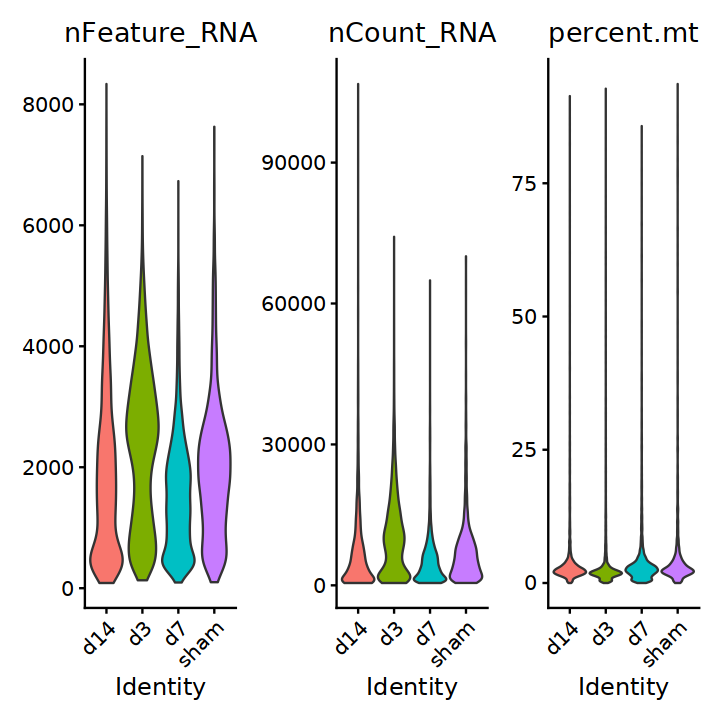

In [152]:
VlnPlot(immune.combined, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3,pt.size = 0,group.by="orig.ident")

In [153]:
library(ggplot2)

In [154]:
#ggsave('figure1.pdf',height =  4,width = 6)

In [155]:
immune.combined <-   subset(immune.combined, subset = nFeature_RNA > 500 & nFeature_RNA < 5000 & percent.mt < 20)

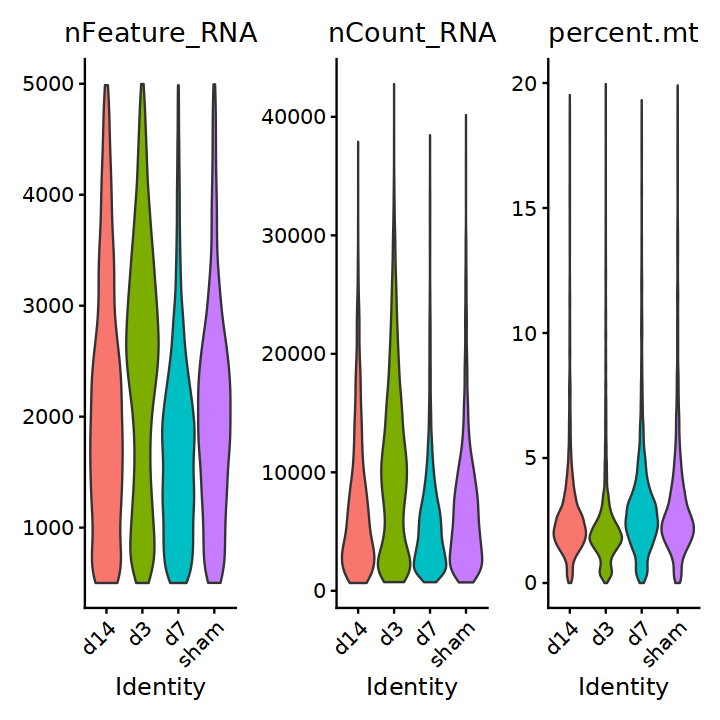

In [156]:
VlnPlot(immune.combined, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3,pt.size = 0,group.by="orig.ident")

In [157]:
table(immune.combined$orig.ident)


 d14   d3   d7 sham 
3006 6677 4534 2625 

### 去除双细胞

In [158]:
library(DoubletFinder)
library(tidyverse)
library(Seurat)
library(patchwork)

In [159]:
immune.combined <-NormalizeData(immune.combined)
immune.combined <- ScaleData(immune.combined,feature=rownames(immune.combined), verbose = FALSE)
immune.combined <- FindVariableFeatures(object = immune.combined,selection.method = 'vst', nfeatures = 2000)
immune.combined <- RunPCA(immune.combined,  features = VariableFeatures(object = immune.combined) ,verbose = FALSE)
immune.combined <- RunUMAP(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- RunTSNE(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindNeighbors(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindClusters(immune.combined)

14:05:41 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

14:05:41 Read 16842 rows and found 20 numeric columns

14:05:41 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

14:05:41 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:05:43 Writing NN index file to temp file /tmp/RtmpZNRZcG/fileae4650c77519

14:05:43 Searching Annoy index using 1 thread, search_k = 3000

14:05:48 Annoy recall = 100%

14:05:49 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:05:50 Initializing from normalized Laplacian + 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 16842
Number of edges: 567992

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8958
Number of communities: 27
Elapsed time: 3 seconds


In [160]:
H9 = immune.combined

In [161]:
paramSweep = function (seu, PCs = 1:20, sct = FALSE, num.cores = 1) 
{
    require(Seurat)
    require(fields)
    require(parallel)
    pK <- c(5e-04, 0.001, 0.005, seq(0.01, 0.3, by = 0.01))
    pN <- seq(0.05, 0.3, by = 0.05)
    min.cells <- round(nrow(seu@meta.data)/(1 - 0.05) - nrow(seu@meta.data))
    pK.test <- round(pK * min.cells)
    pK <- pK[which(pK.test >= 1)]
    orig.commands <- seu@commands
    if (nrow(seu@meta.data) > 10000) {
        real.cells <- rownames(seu@meta.data)[sample(1:nrow(seu@meta.data), 
            10000, replace = FALSE)]
        data <- seu@assays$RNA@counts[, real.cells]
        n.real.cells <- ncol(data)
    }
    if (nrow(seu@meta.data) <= 10000) {
        real.cells <- rownames(seu@meta.data)
        data <- seu@assays$RNA@counts
        n.real.cells <- ncol(data)
    }
    if (num.cores > 1) {
        require(parallel)
        cl <- makeCluster(num.cores)
        output2 <- mclapply(as.list(1:length(pN)), FUN = parallel_paramSweep, 
            n.real.cells, real.cells, pK, pN, data, orig.commands, 
            PCs, sct, mc.cores = num.cores)
        stopCluster(cl)
    }
    else {
        output2 <- lapply(as.list(1:length(pN)), FUN = parallel_paramSweep, 
            n.real.cells, real.cells, pK, pN, data, orig.commands, 
            PCs, sct)
    }
    sweep.res.list <- list()
    list.ind <- 0
    for (i in 1:length(output2)) {
        for (j in 1:length(output2[[i]])) {
            list.ind <- list.ind + 1
            sweep.res.list[[list.ind]] <- output2[[i]][[j]]
        }
    }
    name.vec <- NULL
    for (j in 1:length(pN)) {
        name.vec <- c(name.vec, paste("pN", pN[j], "pK", pK, 
            sep = "_"))
    }
    names(sweep.res.list) <- name.vec
    return(sweep.res.list)
}

In [162]:
sweep.res.list_kidney <- paramSweep(H9, PCs = 1:20, sct = FALSE)

[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


NULL


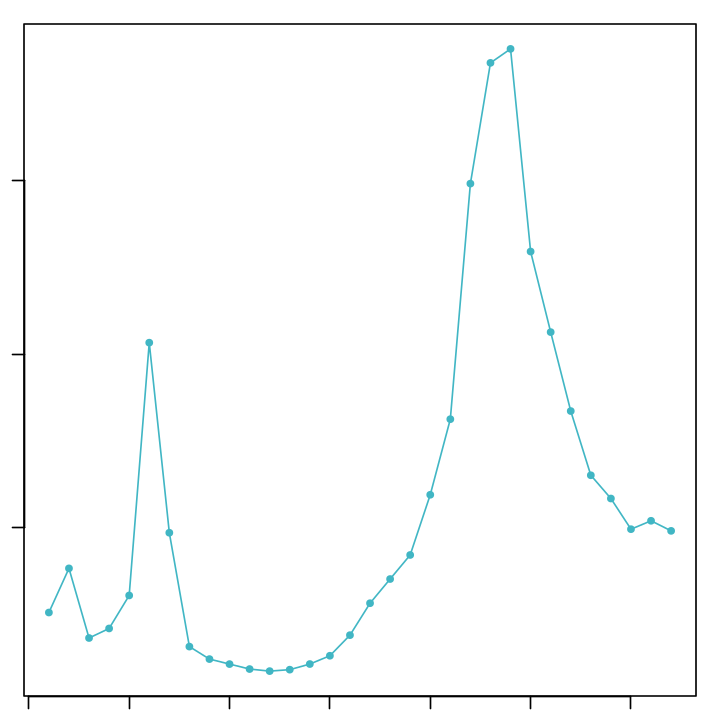

In [163]:
sweep.stats_kidney <- summarizeSweep(sweep.res.list_kidney, GT = FALSE)
bcmvn_kidney <- find.pK(sweep.stats_kidney)

In [164]:
pK_bcmvn <- bcmvn_kidney$pK[which.max(bcmvn_kidney$BCmetric)] %>% as.character() %>% as.numeric()

In [165]:
DoubletRate = ncol(H9)*8*1e-7

In [166]:
DoubletRate

[1] 0.0134736

In [167]:
homotypic.prop <- modelHomotypic(H9$orig.ident)

In [168]:
nExp_poi <- round(DoubletRate*ncol(H9)) 
nExp_poi.adj <- round(nExp_poi*(1-homotypic.prop))

In [169]:
doubletFinder = function (seu, PCs, pN = 0.25, pK, nExp, reuse.pANN = FALSE, 
    sct = FALSE, annotations = NULL) 
{
    require(Seurat)
    require(fields)
    require(KernSmooth)
    if (reuse.pANN != FALSE) {
        pANN.old <- seu@meta.data[, reuse.pANN]
        classifications <- rep("Singlet", length(pANN.old))
        classifications[order(pANN.old, decreasing = TRUE)[1:nExp]] <- "Doublet"
        seu@meta.data[, paste("DF.classifications", pN, pK, nExp, 
            sep = "_")] <- classifications
        return(seu)
    }
    if (reuse.pANN == FALSE) {
        real.cells <- rownames(seu@meta.data)
        data <- seu@assays$RNA@counts[, real.cells]
        n_real.cells <- length(real.cells)
        n_doublets <- round(n_real.cells/(1 - pN) - n_real.cells)
        print(paste("Creating", n_doublets, "artificial doublets...", 
            sep = " "))
        real.cells1 <- sample(real.cells, n_doublets, replace = TRUE)
        real.cells2 <- sample(real.cells, n_doublets, replace = TRUE)
        doublets <- (data[, real.cells1] + data[, real.cells2])/2
        colnames(doublets) <- paste("X", 1:n_doublets, sep = "")
        data_wdoublets <- cbind(data, doublets)
        if (!is.null(annotations)) {
            stopifnot(typeof(annotations) == "character")
            stopifnot(length(annotations) == length(Cells(seu)))
            stopifnot(!any(is.na(annotations)))
            annotations <- factor(annotations)
            names(annotations) <- Cells(seu)
            doublet_types1 <- annotations[real.cells1]
            doublet_types2 <- annotations[real.cells2]
        }
        orig.commands <- seu@commands
        if (sct == FALSE) {
            print("Creating Seurat object...")
            seu_wdoublets <- CreateSeuratObject(counts = data_wdoublets)
            print("Normalizing Seurat object...")
            seu_wdoublets <- NormalizeData(seu_wdoublets, normalization.method = orig.commands$NormalizeData.RNA@params$normalization.method, 
                scale.factor = orig.commands$NormalizeData.RNA@params$scale.factor, 
                margin = orig.commands$NormalizeData.RNA@params$margin)
            print("Finding variable genes...")
            seu_wdoublets <- FindVariableFeatures(seu_wdoublets, 
                selection.method = orig.commands$FindVariableFeatures.RNA$selection.method, 
                loess.span = orig.commands$FindVariableFeatures.RNA$loess.span, 
                clip.max = orig.commands$FindVariableFeatures.RNA$clip.max, 
                mean.function = orig.commands$FindVariableFeatures.RNA$mean.function, 
                dispersion.function = orig.commands$FindVariableFeatures.RNA$dispersion.function, 
                num.bin = orig.commands$FindVariableFeatures.RNA$num.bin, 
                binning.method = orig.commands$FindVariableFeatures.RNA$binning.method, 
                nfeatures = orig.commands$FindVariableFeatures.RNA$nfeatures, 
                mean.cutoff = orig.commands$FindVariableFeatures.RNA$mean.cutoff, 
                dispersion.cutoff = orig.commands$FindVariableFeatures.RNA$dispersion.cutoff)
            print("Scaling data...")
            seu_wdoublets <- ScaleData(seu_wdoublets, features = orig.commands$ScaleData.RNA$features, 
                model.use = orig.commands$ScaleData.RNA$model.use, 
                do.scale = orig.commands$ScaleData.RNA$do.scale, 
                do.center = orig.commands$ScaleData.RNA$do.center, 
                scale.max = orig.commands$ScaleData.RNA$scale.max, 
                block.size = orig.commands$ScaleData.RNA$block.size, 
                min.cells.to.block = orig.commands$ScaleData.RNA$min.cells.to.block)
            print("Running PCA...")
            seu_wdoublets <- RunPCA(seu_wdoublets, features = orig.commands$ScaleData.RNA$features, 
                npcs = length(PCs), rev.pca = orig.commands$RunPCA.RNA$rev.pca, 
                weight.by.var = orig.commands$RunPCA.RNA$weight.by.var, 
                verbose = FALSE)
            pca.coord <- seu_wdoublets@reductions$pca@cell.embeddings[, 
                PCs]
            cell.names <- rownames(seu_wdoublets@meta.data)
            nCells <- length(cell.names)
            rm(seu_wdoublets)
            gc()
        }
        if (sct == TRUE) {
            require(sctransform)
            print("Creating Seurat object...")
            seu_wdoublets <- CreateSeuratObject(counts = data_wdoublets)
            print("Running SCTransform...")
            seu_wdoublets <- SCTransform(seu_wdoublets)
            print("Running PCA...")
            seu_wdoublets <- RunPCA(seu_wdoublets, npcs = length(PCs))
            pca.coord <- seu_wdoublets@reductions$pca@cell.embeddings[, 
                PCs]
            cell.names <- rownames(seu_wdoublets@meta.data)
            nCells <- length(cell.names)
            rm(seu_wdoublets)
            gc()
        }
        print("Calculating PC distance matrix...")
        dist.mat <- fields::rdist(pca.coord)
        print("Computing pANN...")
        pANN <- as.data.frame(matrix(0L, nrow = n_real.cells, 
            ncol = 1))
        if (!is.null(annotations)) {
            neighbor_types <- as.data.frame(matrix(0L, nrow = n_real.cells, 
                ncol = length(levels(doublet_types1))))
        }
        rownames(pANN) <- real.cells
        colnames(pANN) <- "pANN"
        k <- round(nCells * pK)
        for (i in 1:n_real.cells) {
            neighbors <- order(dist.mat[, i])
            neighbors <- neighbors[2:(k + 1)]
            pANN$pANN[i] <- length(which(neighbors > n_real.cells))/k
            if (!is.null(annotations)) {
                for (ct in unique(annotations)) {
                  neighbors_that_are_doublets = neighbors[neighbors > 
                    n_real.cells]
                  if (length(neighbors_that_are_doublets) > 0) {
                    neighbor_types[i, ] <- table(doublet_types1[neighbors_that_are_doublets - 
                      n_real.cells]) + table(doublet_types2[neighbors_that_are_doublets - 
                      n_real.cells])
                    neighbor_types[i, ] <- neighbor_types[i, 
                      ]/sum(neighbor_types[i, ])
                  }
                  else {
                    neighbor_types[i, ] <- NA
                  }
                }
            }
        }
        print("Classifying doublets..")
        classifications <- rep("Singlet", n_real.cells)
        classifications[order(pANN$pANN[1:n_real.cells], decreasing = TRUE)[1:nExp]] <- "Doublet"
        seu@meta.data[, paste("pANN", pN, pK, nExp, sep = "_")] <- pANN[rownames(seu@meta.data), 
            1]
        seu@meta.data[, paste("DF.classifications", pN, pK, nExp, 
            sep = "_")] <- classifications
        if (!is.null(annotations)) {
            colnames(neighbor_types) = levels(doublet_types1)
            for (ct in levels(doublet_types1)) {
                seu@meta.data[, paste("DF.doublet.contributors", 
                  pN, pK, nExp, ct, sep = "_")] <- neighbor_types[, 
                  ct]
            }
        }
        return(seu)
    }
}

In [170]:
scRNA <- doubletFinder(H9, PCs = 1:20, pN = 0.25, pK = pK_bcmvn, 
                          nExp = nExp_poi.adj, reuse.pANN = F, sct = F)

[1] "Creating 5614 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


In [171]:
colnames(scRNA@meta.data)

[1] "orig.ident"                       "nCount_RNA"                      
[3] "nFeature_RNA"                     "percent.mt"                      
[5] "RNA_snn_res.0.8"                  "seurat_clusters"                 
[7] "pANN_0.25_0.22_162"               "DF.classifications_0.25_0.22_162"

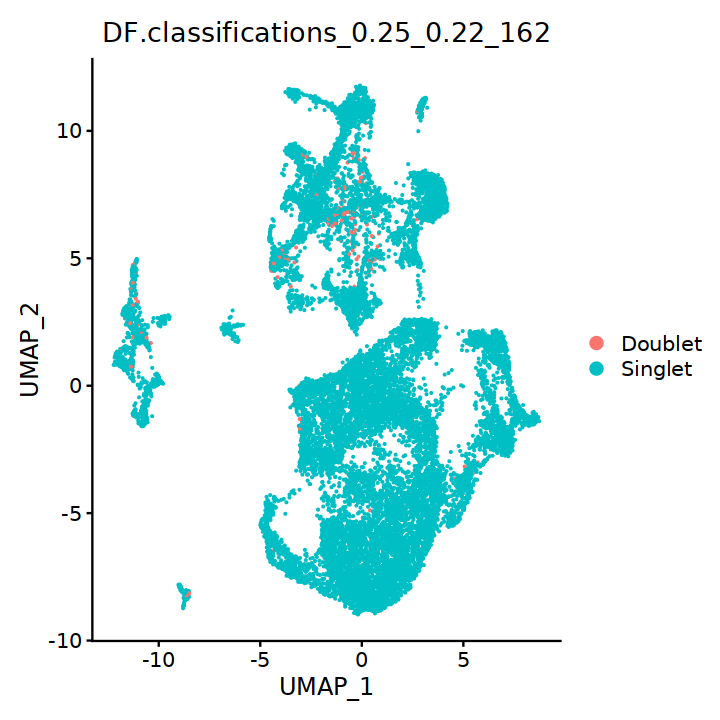

In [172]:
DimPlot(scRNA, reduction = "umap", group.by = "DF.classifications_0.25_0.22_162")

In [173]:
immune.combined = subset(scRNA, subset = DF.classifications_0.25_0.22_162  != 'Doublet')

In [174]:
table(immune.combined$orig.ident)


 d14   d3   d7 sham 
2928 6660 4514 2578 

In [175]:
ifnb.list <- SplitObject(immune.combined, split.by = "orig.ident")

testAB.anchors <- FindIntegrationAnchors(object.list = ifnb.list, dims = 1:20)
testAB.integrated <- IntegrateData(anchorset = testAB.anchors, dims = 1:20)

DefaultAssay(testAB.integrated) <- "integrated"
# Run the standard workflow for visualization and clustering
testAB.integrated <- ScaleData(testAB.integrated, features = rownames(testAB.integrated))
testAB.integrated <- RunPCA(testAB.integrated, npcs = 50, verbose = FALSE)
testAB.integrated <- FindNeighbors(testAB.integrated, dims = 1:30)
testAB.integrated <- FindClusters(testAB.integrated, resolution = 0.5)
testAB.integrated <- RunUMAP(testAB.integrated, dims = 1:30)
testAB.integrated <- RunTSNE(testAB.integrated, dims = 1:30)

immune.combined = testAB.integrated

Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6930 anchors

Filtering anchors

	Retained 3772 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6258 anchors

Filtering anchors

	Retained 4565 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9489 anchors

Filtering anchors

	Retained 4520 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5584 anchors

Filtering anchors

	Retained 4739 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 7545 anchors

Filtering anchors

	Retained 4215 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 7048 anchors

Filtering anchors

	Retained 6028 anchors

Merging dataset 4 into 3

Extracting anchors for merged samples

Finding integration vecto

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 16680
Number of edges: 650446

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9145
Number of communities: 21
Elapsed time: 5 seconds


14:16:48 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

14:16:48 Read 16680 rows and found 30 numeric columns

14:16:48 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

14:16:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:16:50 Writing NN index file to temp file /tmp/RtmpZNRZcG/fileae464491fe5e

14:16:50 Searching Annoy index using 1 thread, search_k = 3000

14:16:55 Annoy recall = 100%

14:16:56 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:16:57 Initializing from normalized Laplacian + 

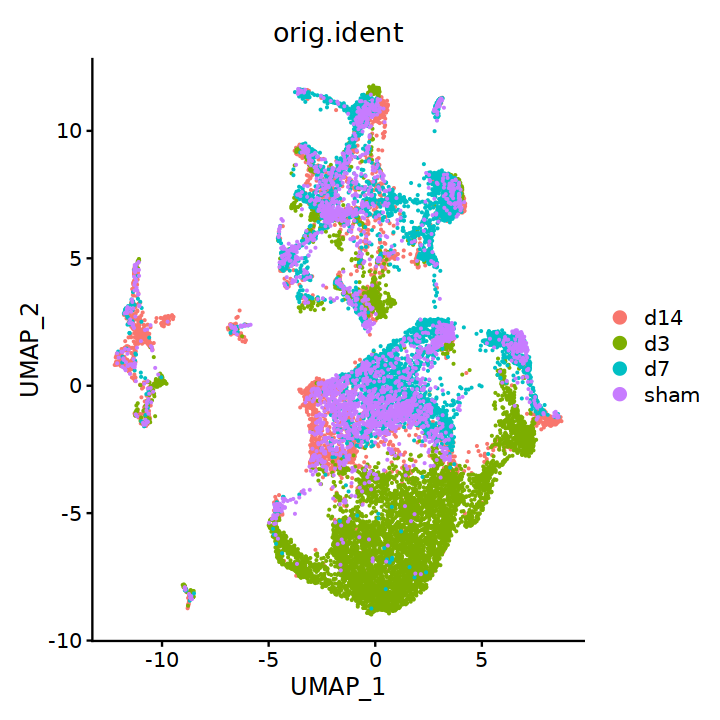

In [176]:
DimPlot(scRNA, reduction = "umap", group.by = "orig.ident")

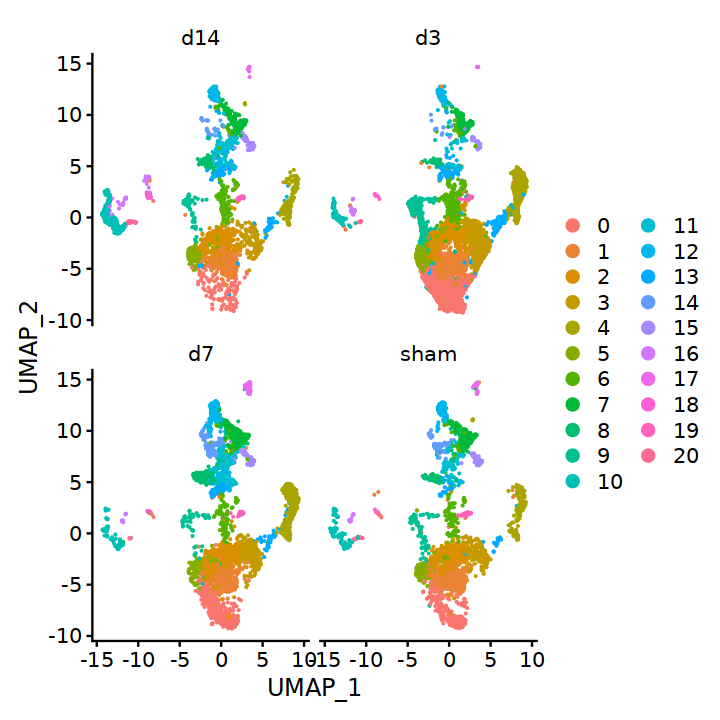

In [177]:
DimPlot(immune.combined, reduction = "umap", split.by  = "orig.ident",ncol = 2)

In [178]:
scRNA = immune.combined

In [179]:
library(Seurat) ##
library(SingleR)
library(ggplot2)
library(reshape2)
mouseImmu  = get(load('/import/DB/SingleR_ref/ref_Mouse_all.RData'))
pbmc_for_SingleR <- GetAssayData(scRNA, slot="data") ##获取标准化矩阵
clusters=scRNA@meta.data$seurat_clusters
pred.mouseImmu <- SingleR(test = pbmc_for_SingleR, ref = mouseImmu, labels = mouseImmu$label.fine,
 method = "cluster", clusters = clusters, 
 assay.type.test = "logcounts", assay.type.ref = "logcounts")
celltype = data.frame(ClusterID=rownames(pred.mouseImmu), celltype=pred.mouseImmu$labels, stringsAsFactors = FALSE)

Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames =

In [180]:
scRNA@meta.data$celltype = "NA"
# 赋值
for(i in 1:nrow(celltype)){
  scRNA@meta.data[which(scRNA@meta.data$seurat_clusters == celltype$ClusterID[i]),'celltype'] <- celltype$celltype[i]}

In [181]:
scRNA

An object of class Seurat 
33053 features across 16680 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, tsne

In [182]:
Idents(scRNA) = 'orig.ident'

In [183]:
DefaultAssay(scRNA) = 'RNA'

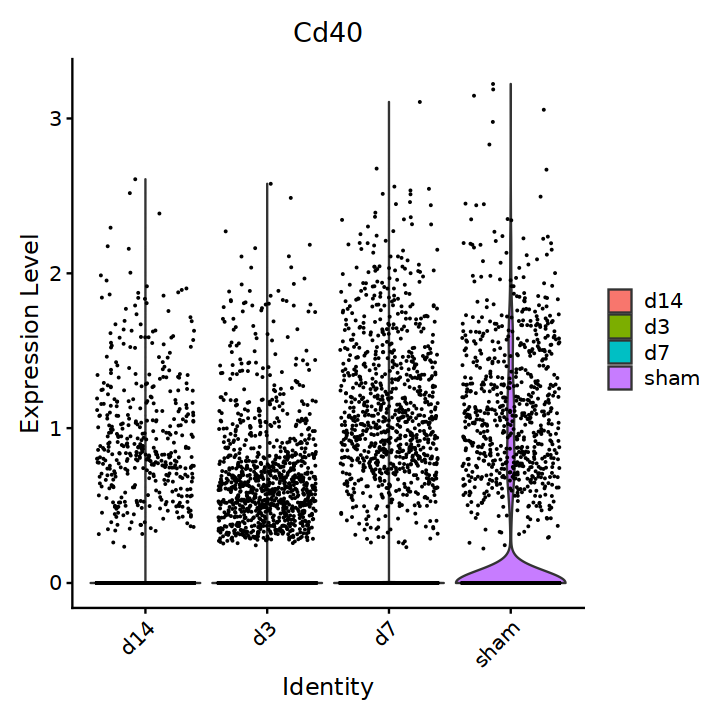

In [184]:
VlnPlot(scRNA,'Cd40')

In [185]:
library(Seurat)

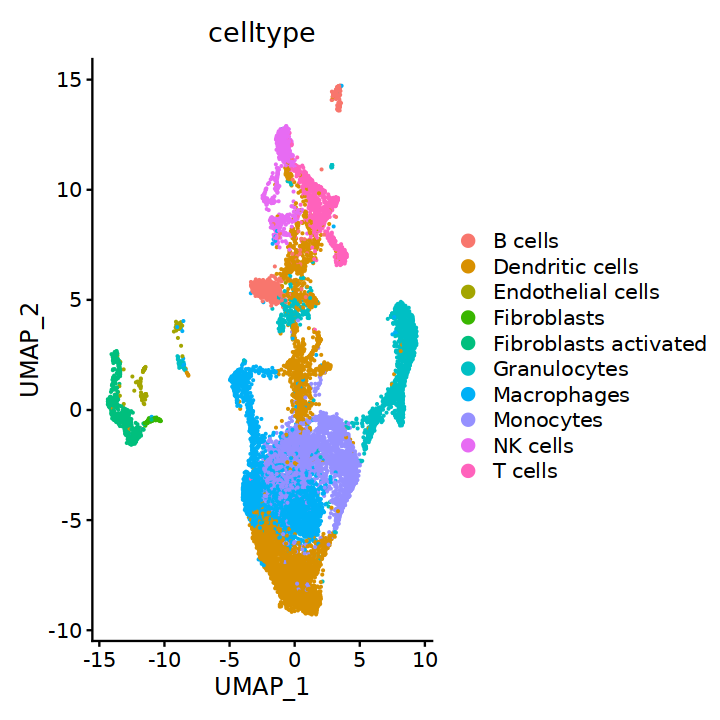

In [186]:
DimPlot(scRNA, group.by="celltype", label=F, label.size=5, reduction='umap')

In [187]:
library(ggplot2)

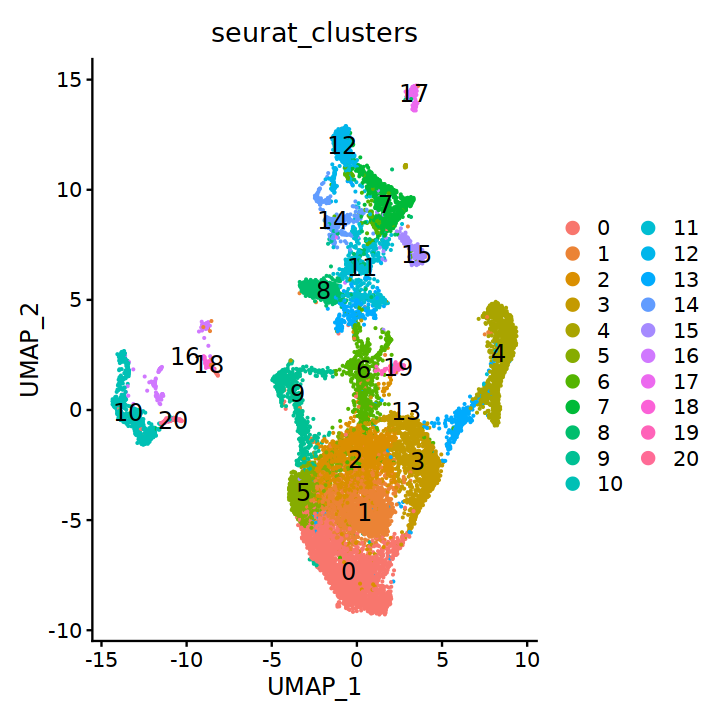

In [188]:
DimPlot(scRNA, group.by="seurat_clusters", label=T, label.size=5, reduction='umap')

In [189]:
table(scRNA$orig.ident)


 d14   d3   d7 sham 
2928 6660 4514 2578 

In [190]:
saveRDS(scRNA,file = 'outsider.4.sample.rds')

In [191]:
Idents(scRNA) = 'seurat_clusters'

In [192]:
scedata = scRNA

In [193]:
Idents(scRNA) = 'seurat_clusters'

In [194]:
options(repr.plot.height = 6)

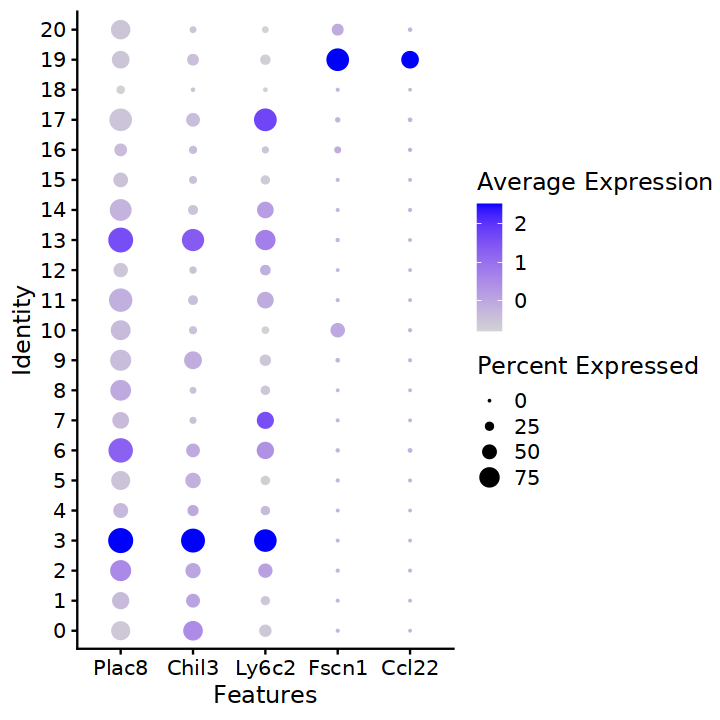

In [195]:
DotPlot(scRNA,features = c('Plac8','Chil3','Ly6c2','Fscn1','Ccl22'))


 d14   d3   d7 sham 
2928 6660 4514 2578 


              T cells          Granulocytes       Dendritic cells 
          0.066366906           0.117446043           0.250239808 
             NK cells     Endothelial cells Fibroblasts activated 
          0.054916067           0.012110312           0.039328537 
              B cells           Macrophages             Monocytes 
          0.054856115           0.204976019           0.194664269 
          Fibroblasts 
          0.005095923 

                       
                         d14   d3   d7 sham
  T cells                252  183  424  248
  Granulocytes           348  844  565  202
  Dendritic cells        459 2177 1007  531
  NK cells               181   95  433  207
  Endothelial cells      145   36    8   13
  Fibroblasts activated  407  107   55   87
  B cells                 76   59  654  126
  Macrophages            556 1674  582  607
  Monocytes              445 1476  781  545
  Fibroblasts             59    9    5   12

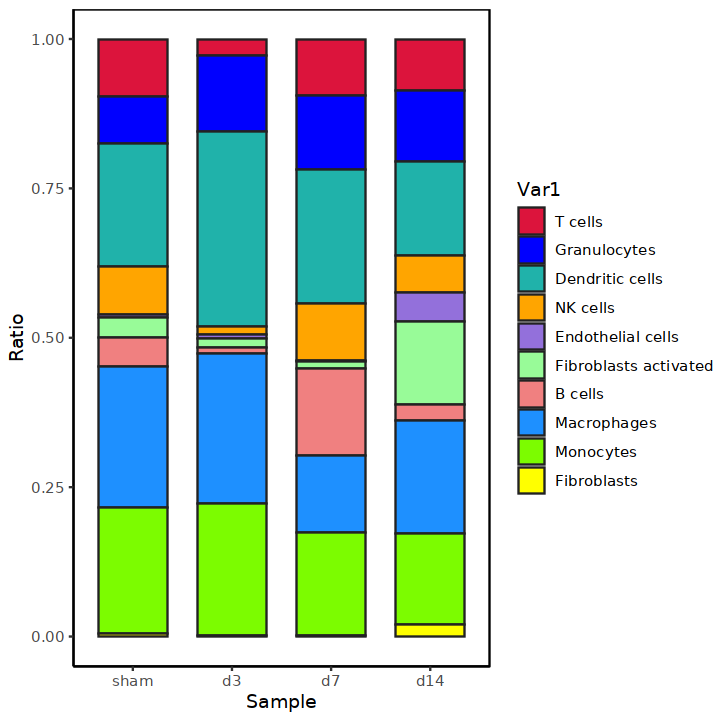

In [196]:
Idents(scRNA) ='celltype'

scedata = scRNA
table(scedata$orig.ident)#查看各组细胞数
prop.table(table(Idents(scedata)))
table(Idents(scedata), scedata$orig.ident)#各组不同细胞群细胞数
Cellratio <- prop.table(table(Idents(scedata), scedata$orig.ident), margin = 2)#计算各组样本不同细胞群比例
Cellratio <- as.data.frame(Cellratio)

Cellratio$Var2 = factor(Cellratio$Var2,levels = c('sham',  'd3', 'd7', 'd14'))

allcolour=c("#DC143C","#0000FF","#20B2AA","#FFA500","#9370DB","#98FB98","#F08080","#1E90FF","#7CFC00","#FFFF00",
            "#808000","#FF00FF","#FA8072","#7B68EE","#9400D3","#800080","#A0522D","#D2B48C","#D2691E","#87CEEB","#40E0D0","#5F9EA0",
            "#FF1493","#0000CD","#008B8B","#FFE4B5","#8A2BE2","#228B22","#E9967A","#4682B4","#32CD32","#F0E68C","#FFFFE0","#EE82EE",
            "#FF6347","#6A5ACD","#9932CC","#8B008B","#8B4513","#DEB887")
library(ggplot2)
ggplot(Cellratio) + 
  geom_bar(aes(x =Var2, y= Freq, fill = Var1),stat = "identity",width = 0.7,size = 0.5,colour = '#222222')+ 
  theme_classic() +
  labs(x='Sample',y = 'Ratio')+
  scale_fill_manual(values = allcolour)+
  theme(panel.border = element_rect(fill=NA,color="black", size=0.5, linetype="solid"))

library(Seurat)
library(ggplot2)
library(dplyr)
library(ggalluvial)

## 往下都是没有运行的

In [197]:
options(repr.plot.height = 6,rpr.plot.wdith = 5)

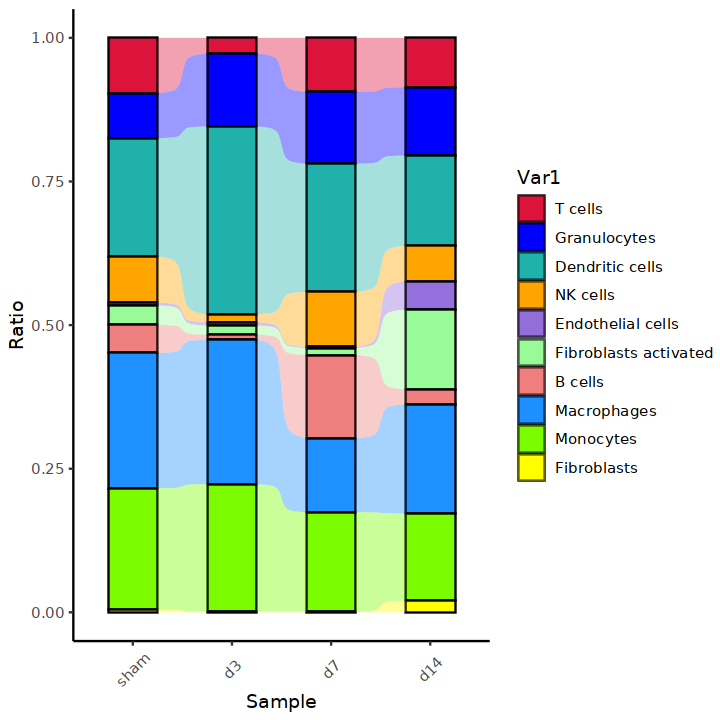

In [198]:
ggplot(Cellratio, aes(x =Var2, y= Freq, fill = Var1,
                  stratum=Var1, alluvium=Var1)) +
  geom_col(width = 0.5, color='black')+
  geom_flow(width=0.5,alpha=0.4, knot.pos=0.5)+ # 参数knot.pos设置为0.5使连接为曲线面积，就像常见的桑基图
  theme_classic() +
  labs(x='Sample',y = 'Ratio')+
  scale_fill_manual(values = allcolour) + theme(axis.text.x = element_text(angle = 45, 
 vjust = 0.5, hjust=0.5))

In [199]:
Idents(scRNA) = 'celltype'

In [200]:
myeloid = subset(scRNA, idents= c('Macrophages','Monocytes','Dendritic cells'))

In [202]:
saveRDS(myeloid,file = 'outsider.4.sample.myeloid.rds')

In [92]:
immune.combined = myeloid

In [93]:
ifnb.list <- SplitObject(immune.combined, split.by = "orig.ident")
testAB.anchors <- FindIntegrationAnchors(object.list = ifnb.list, dims = 1:20)
testAB.integrated <- IntegrateData(anchorset = testAB.anchors, dims = 1:20)
DefaultAssay(testAB.integrated) <- "integrated"
# Run the standard workflow for visualization and clustering
testAB.integrated <- ScaleData(testAB.integrated, features = rownames(testAB.integrated))
testAB.integrated <- RunPCA(testAB.integrated, npcs = 20, verbose = FALSE)
testAB.integrated <- FindNeighbors(testAB.integrated, dims = 1:20)
testAB.integrated <- FindClusters(testAB.integrated, resolution = 0.5)

Computing 2000 integration features

No variable features found for object1 in the object.list. Running FindVariableFeatures ...

No variable features found for object2 in the object.list. Running FindVariableFeatures ...

No variable features found for object3 in the object.list. Running FindVariableFeatures ...

No variable features found for object4 in the object.list. Running FindVariableFeatures ...

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5198 anchors

Filtering anchors

	Retained 2559 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4377 anchors

Filtering anchors

	Retained 3043 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 7236 anchors

Filtering anchors

	Retained 3869 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3916 anchors

Filtering anchors

	Retained 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10609
Number of edges: 378989

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8744
Number of communities: 14
Elapsed time: 2 seconds


In [94]:
testAB.integrated <- RunUMAP(testAB.integrated, dims = 1:20)
testAB.integrated <- RunTSNE(testAB.integrated, dims = 1:20)
immune.combined = testAB.integrated

04:32:57 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

04:32:57 Read 10609 rows and found 20 numeric columns

04:32:57 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

04:32:57 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:32:58 Writing NN index file to temp file /tmp/RtmpZNRZcG/fileae4624f96199

04:32:58 Searching Annoy index using 1 thread, search_k = 3000

04:33:01 Annoy recall = 100%

04:33:02 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:33:03 Initializing from normalized Laplacian + 

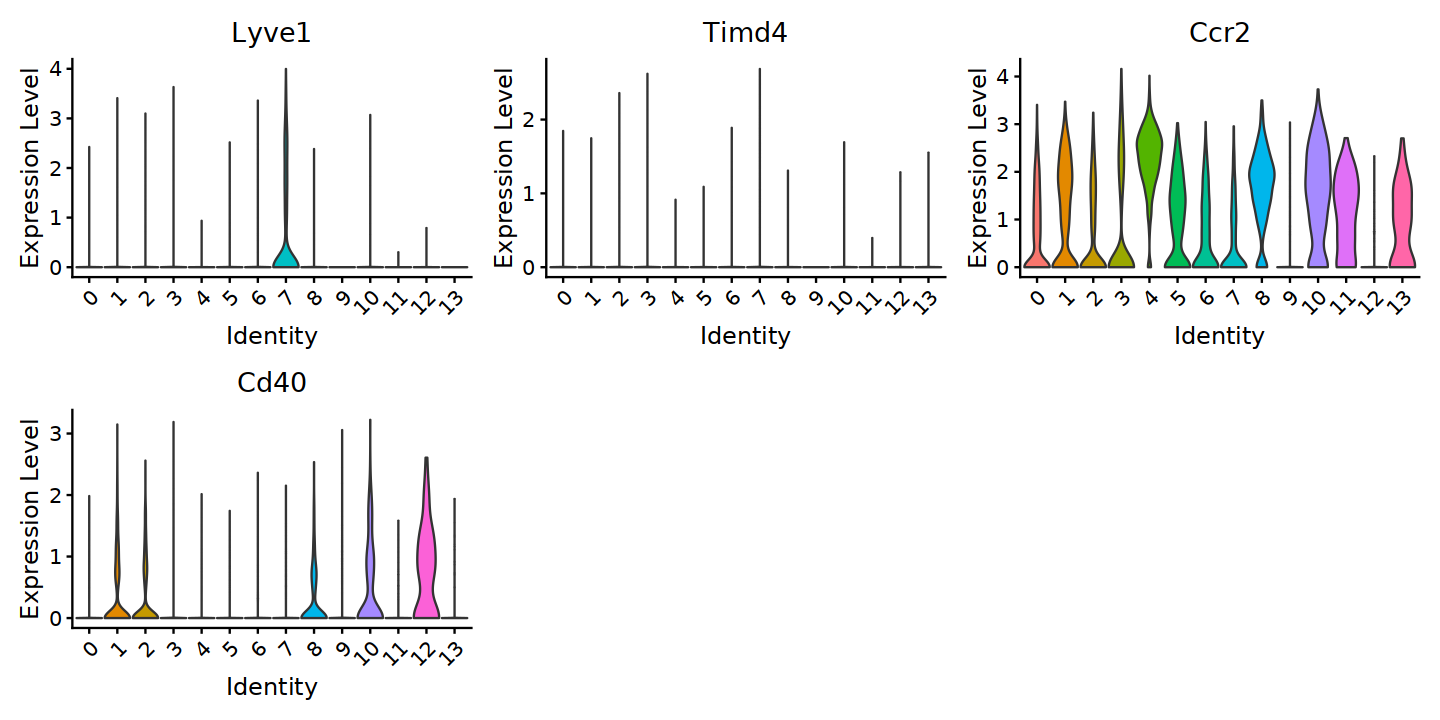

In [95]:
DefaultAssay(immune.combined)='RNA'

Idents(immune.combined) = 'seurat_clusters'

VlnPlot(immune.combined,features = c('Lyve1','Timd4','Ccr2','Cd40'),pt.size = 0)

In [96]:
options(repr.plot.width = 12)

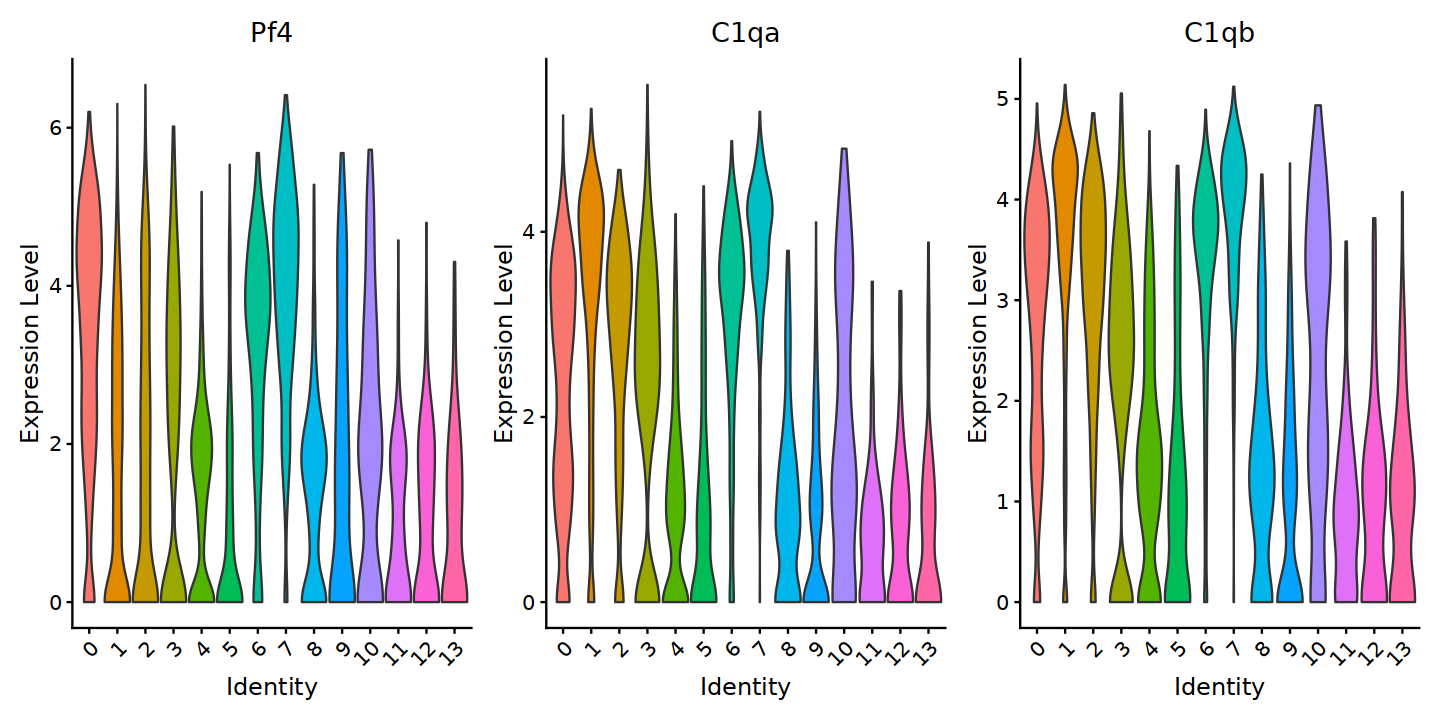

In [97]:
VlnPlot(immune.combined,features = c('Pf4','C1qa','C1qb'),pt.size = 0)

In [98]:
DefaultAssay(immune.combined) = 'RNA'
Idents(immune.combined) = 'seurat_clusters'

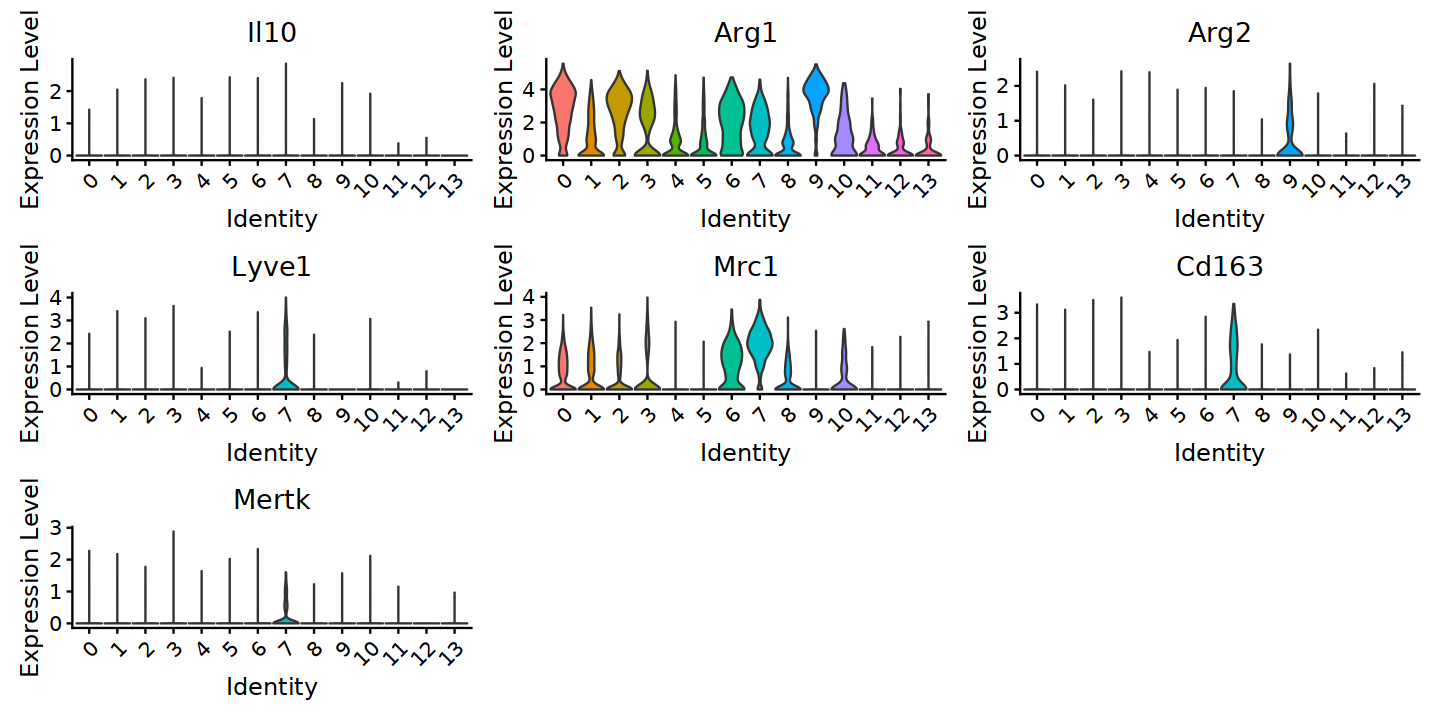

In [99]:
VlnPlot(immune.combined,features = c('Il10','Arg1','Arg2','Lyve1','Mrc1','Cd163','Mertk'),pt.size = 0)

In [68]:
Idents(immune.combined) = 'orig.ident'

In [69]:
table(Idents(immune.combined),immune.combined$seurat_clusters)

      
         0   1   2   3   4   5   6   7   8   9  10  11  12  13  14
  d14  271  76 247  98  54  74 191 175  66  78  23  36  22  26  23
  d3   462 904 410 623 722 415 431 174 505 281 228  30  60  47  35
  d7   474 357 290 189 110 190  76 272  44  58  84 144  36  21  25
  sham 350 211 310 117  58 150 105 145  79  50  35  21  20  21  11

In [100]:
table(immune.combined$orig.ident)


 d14   d3   d7 sham 
1424 5297 2226 1662 

In [101]:
Idents(immune.combined) = 'orig.ident'

In [102]:
outdata.d3.d7 = subset(immune.combined,idents = c('d3','d7'))

In [103]:
saveRDS(outdata.d3.d7,file = 'outdata.d3.d7.rds')

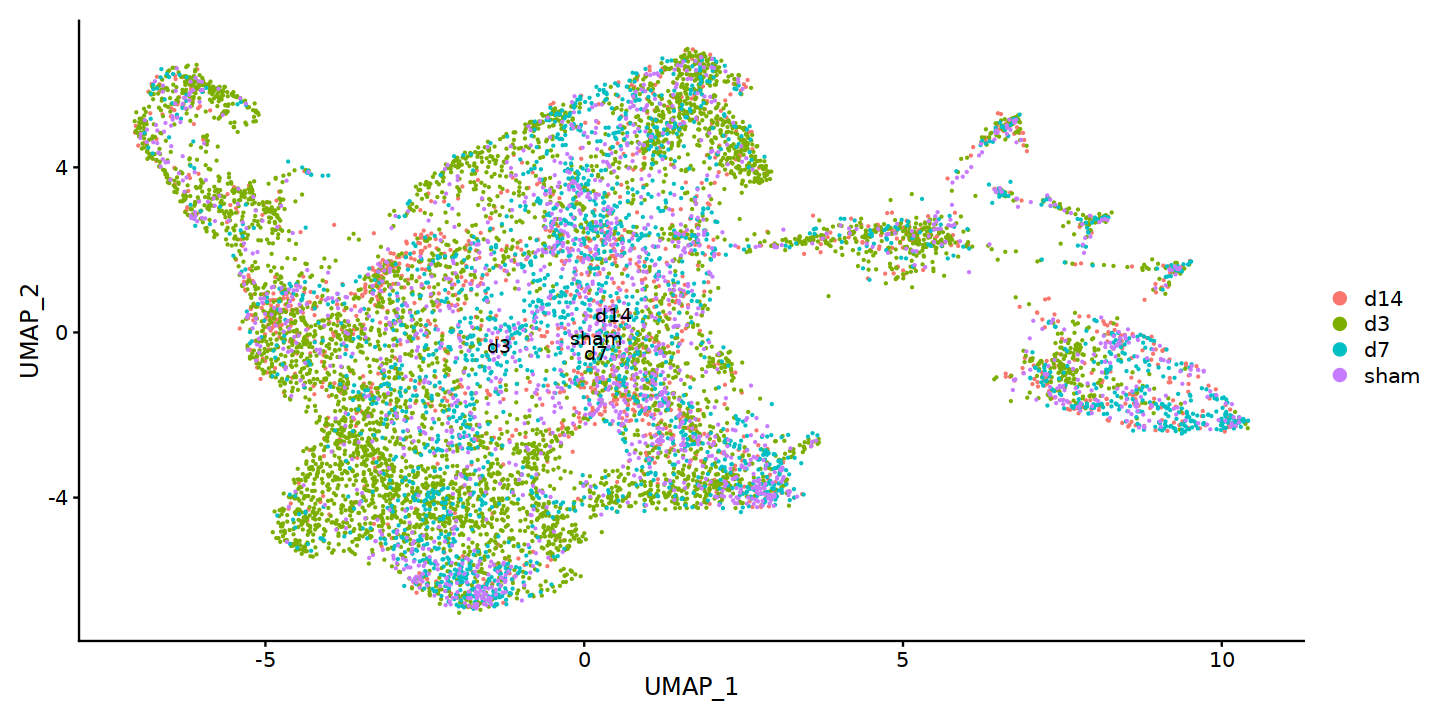

In [108]:
DimPlot(immune.combined,label = T)

In [110]:
DefaultAssay(immune.combined) = 'RNA'

Idents(immune.combined) = 'seurat_clusters'
sce.markers <- FindAllMarkers(object = immune.combined, only.pos = TRUE, 
                              min.pct = 0.25, 
                              thresh.use = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13



In [97]:
write.csv(sce.markers,file ='outsider.diff.gene.csv')

### 3d

In [104]:
Idents(immune.combined) = 'orig.ident'

d7 = subset(immune.combined,idents = 'd7')

DefaultAssay(d7)='RNA'

Idents(d7) = 'seurat_clusters'


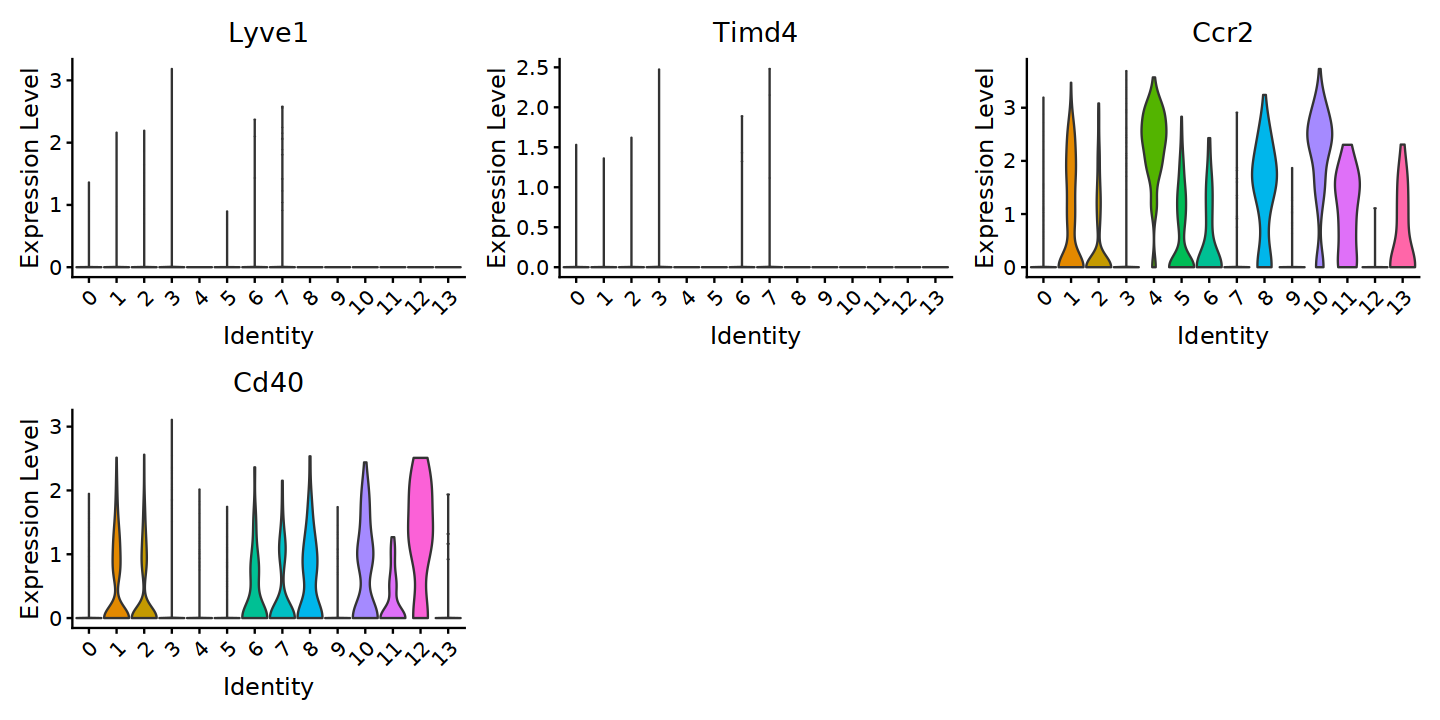

In [105]:
VlnPlot(d7,features = c('Lyve1','Timd4','Ccr2','Cd40'),pt.size = 0)

In [111]:
library(dplyr)
top5 <- sce.markers %>% group_by(cluster) %>% top_n(5, avg_log2FC)
library(ggplot2)

In [113]:
options(repr.plot.height = 15,repr.plot.width = 6)

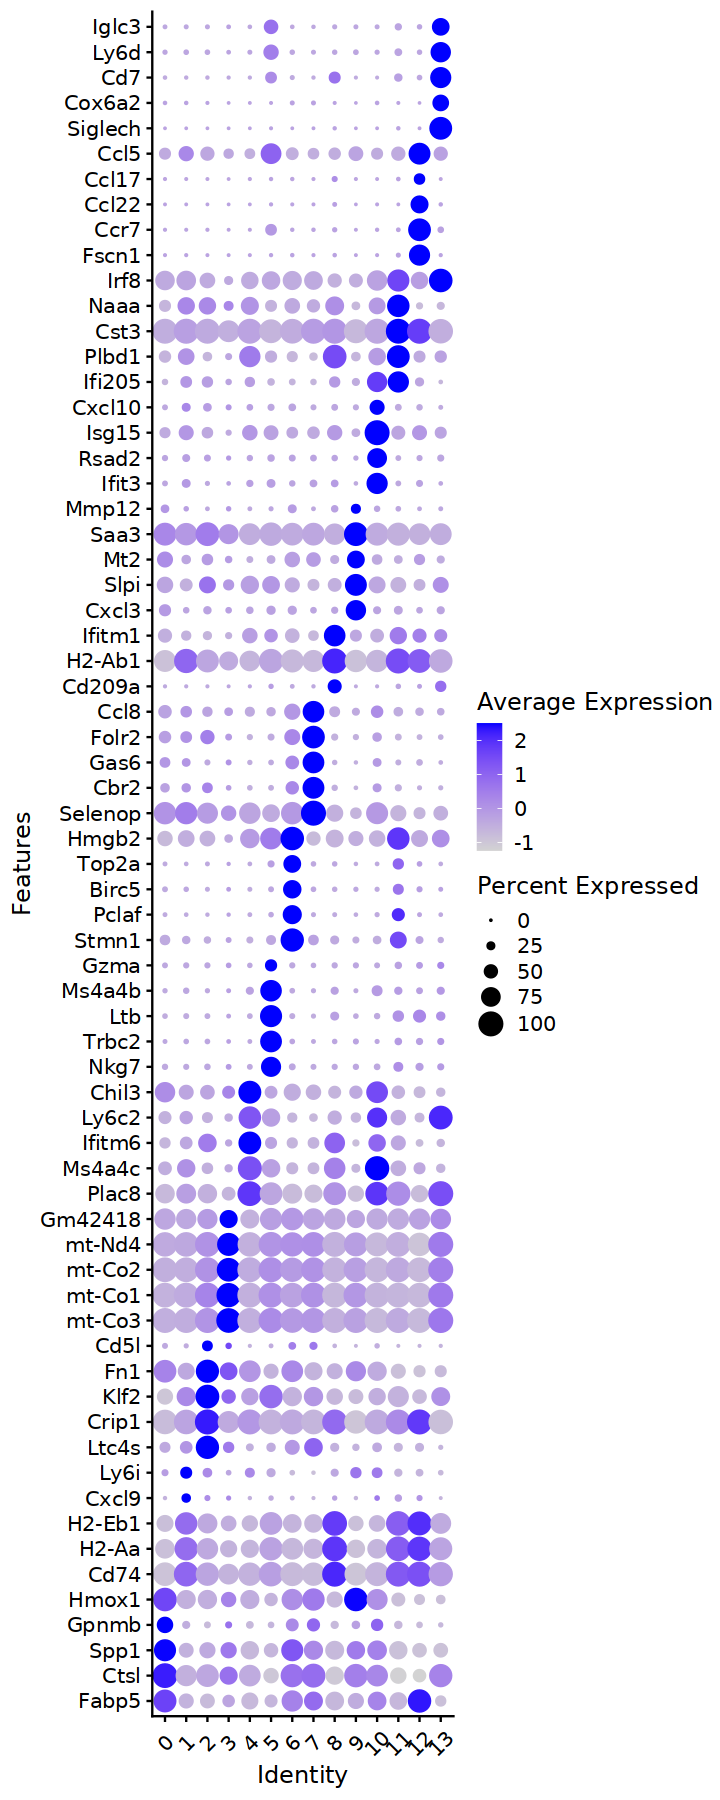

In [114]:
DotPlot(immune.combined, features = unique(top5$gene),
 assay='RNA' ) + coord_flip()+ theme(axis.text.x = element_text(angle = 45, 
 vjust = 0.5, hjust=0.5))

In [ ]:
Idents(immune.combined) = 'orig.ident'

d3 = subset(immune.combined,idents = 'd3')

DefaultAssay(d3)='RNA'

Idents(d3) = 'seurat_clusters'

VlnPlot(d3,features = c('Lyve1','Timd4','Ccr2','Cd40'),pt.size = 0)

In [ ]:
Idents(immune.combined) = 'orig.ident'

d14 = subset(immune.combined,idents = 'd14')

DefaultAssay(d14)='RNA'

Idents(d14) = 'seurat_clusters'

VlnPlot(d14,features = c('Lyve1','Timd4','Ccr2','Cd40'),pt.size = 0)

In [ ]:
Idents(immune.combined) = 'orig.ident'

sham = subset(immune.combined,idents = 'sham')

DefaultAssay(sham)='RNA'

Idents(sham) = 'seurat_clusters'

VlnPlot(sham,features = c('Lyve1','Timd4','Ccr2','Cd40'),pt.size = 0)

In [ ]:
Idents(immune.combined) = 'seurat_clusters'

In [ ]:
VlnPlot(immune.combined,features = c('Ccr7','Cd68','Cd163'),pt.size = 0)

In [ ]:
Idents(immune.combined) = 'orig.ident'

In [ ]:
VlnPlot(immune.combined,features = 'Cd40')

In [ ]:
Idents(scRNA) = 'seurat_clusters'

In [ ]:
Idents(scRNA) = 'celltype'

sce.markers <- FindAllMarkers(object = scRNA, only.pos = TRUE, 
                              min.pct = 0.25, 
                              thresh.use = 0.25)
 

library(dplyr) 
# 不同seurat版本的 avg_logFC 不一样 
top5 <- sce.markers %>% group_by(cluster) %>% top_n(5, avg_log2FC)



### https://zhuanlan.zhihu.com/p/573321126
## https://zhuanlan.zhihu.com/p/594345612


In [ ]:
# options(repr.plot.height = 9,repr.plot.width = 7)

#  DotPlot(scRNA, features = unique(top5$gene) ,
#  assay='RNA' ) + coord_flip()+ theme(axis.text.x = element_text(angle = 45, 
#  vjust = 0.5, hjust=0.5))

In [ ]:
ggsave('figure7.pdf',height =  9,width = 8)

In [ ]:
library('clusterProfiler')

In [11]:
library(dplyr) 
top50 <- sce.markers %>% group_by(cluster) %>% top_n(50, avg_log2FC)

group <- data.frame(gene=top50$gene,
                    group=top50$cluster)

Gene_ID <- bitr(top50$gene, fromType="SYMBOL", 
            toType="ENTREZID", 
            OrgDb="org.Mm.eg.db")
data  <- merge(Gene_ID,group,by.x='SYMBOL',by.y='gene')
data_GO <- compareCluster(
  ENTREZID~group, 
  data=data, 
  fun="enrichGO", 
  OrgDb="org.Mm.eg.db",
  ont = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff = 0.05,
  qvalueCutoff = 0.05,
  readable = TRUE
)





'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(top50$gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Mm.eg.db"):
"2.93% of input gene IDs are fail to map..."


In [21]:
top50

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0,2.524560,0.946,0.676,0,Monocytes,H2-Ab1
0,2.352975,0.880,0.439,0,Monocytes,Ms4a4c
0,2.336550,0.876,0.703,0,Monocytes,Plac8
0,2.302972,0.936,0.590,0,Monocytes,H2-Aa
0,2.282660,0.931,0.600,0,Monocytes,H2-Eb1
0,2.272464,0.915,0.372,0,Monocytes,Ms4a6c
0,2.256347,0.976,0.730,0,Monocytes,Cd74
0,2.184324,0.935,0.664,0,Monocytes,S100a4
0,2.162664,0.949,0.695,0,Monocytes,Lyz2


In [12]:
data_GO_sim <- simplify(data_GO, 
                        cutoff=0.5, 
                        by="p.adjust", 
                        select_fun=min)

write.csv(data_GO_sim@compareClusterResult,file = 'enrichment.csv',row.names =F)

In [13]:
options(repr.plot.height = 9,repr.plot.width = 7)
enrichplot::dotplot(data_GO_sim, showCategory=4,font.size = 8)+ theme(axis.text.x = element_text(angle = 45, 
 vjust = 0.5, hjust=0.5))

ERROR: Error in theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 0.5)): could not find function "theme"


In [242]:
ggsave('figure8.pdf',height =  9,width = 8)

In [163]:
saveRDS(scRNA ,file = 'after_rename.rds')